In [27]:
import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [28]:
import pathlib
data_dir = r'O:\source\repos\EVE-Online-Bot\training_data_miner'
data_dir = pathlib.Path(data_dir)

In [29]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

395


In [30]:
batch_size = 1
img_height = 65
img_width = 290

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 395 files belonging to 5 classes.
Using 316 files for training.


In [32]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 395 files belonging to 5 classes.
Using 79 files for validation.


In [33]:
class_names = train_ds.class_names
print(class_names)

['both_running', 'invalid', 'miner_1_running', 'miner_2_running', 'no_miners_running']


In [34]:
f = open(r'O:\source\repos\EVE-Online-Bot\training_data_miner\mining_tools_classes.json', "w")
f.write(json.dumps(class_names))
f.close()

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
316/316 [==============================] - 9s 27ms/step - loss: 1.3307 - accuracy: 0.4905 - val_loss: 1.0626 - val_accuracy: 0.4810
Epoch 2/10
316/316 [==============================] - 9s 29ms/step - loss: 0.0787 - accuracy: 0.9715 - val_loss: 6.1628e-04 - val_accuracy: 1.0000
Epoch 3/10
316/316 [==============================] - 11s 34ms/step - loss: 2.1665e-04 - accuracy: 1.0000 - val_loss: 1.7275e-04 - val_accuracy: 1.0000
Epoch 4/10
316/316 [==============================] - 9s 29ms/step - loss: 6.6882e-05 - accuracy: 1.0000 - val_loss: 6.9400e-05 - val_accuracy: 1.0000
Epoch 5/10
316/316 [==============================] - 8s 24ms/step - loss: 2.5314e-05 - accuracy: 1.0000 - val_loss: 3.5076e-05 - val_accuracy: 1.0000
Epoch 6/10
316/316 [==============================] - 11s 36ms/step - loss: 1.2325e-05 - accuracy: 1.0000 - val_loss: 1.6399e-05 - val_accuracy: 1.0000
Epoch 7/10
316/316 [==============================] - 8s 24ms/step - loss: 6.2705e-06 - accuracy: 1.0000

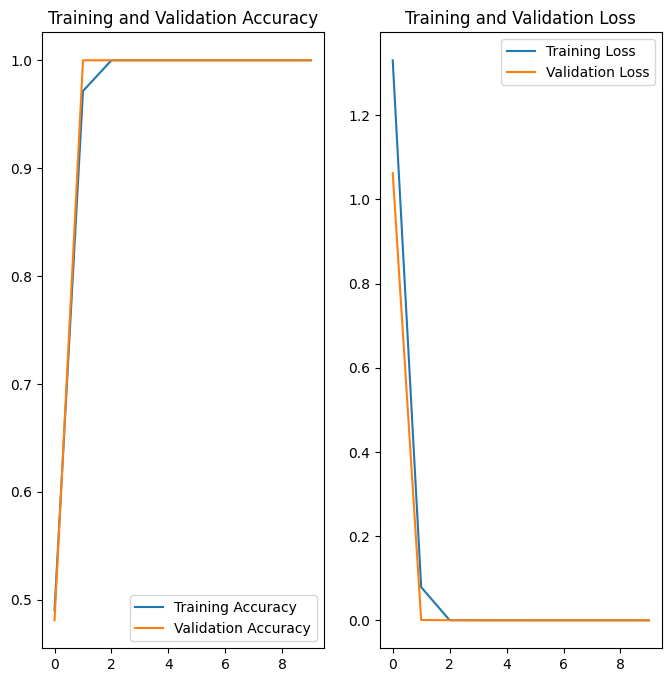

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model.save(r'O:\source\repos\EVE-Online-Bot\training_data_miner\mining_tools_state.h5')

In [25]:
new_model = tf.keras.models.load_model(r'O:\source\repos\EVE-Online-Bot\training_data_miner\mining_tools_state.h5')

In [40]:
f = open(r'O:\source\repos\EVE-Online-Bot\training_data_miner\mining_tools_classes.json', "r")
classes = json.loads(f.read())

In [41]:
classes

['both_running',
 'invalid',
 'miner_1_running',
 'miner_2_running',
 'no_miners_running']

In [48]:
in_flight = list(data_dir.glob('invalid/*.png'))
img = tf.keras.utils.load_img(
    in_flight[0], target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to invalid with a 100.00 percent confidence.
